## Packages

In [1451]:
from sklearn.datasets import make_moons, make_circles
from pandas import DataFrame
import matplotlib.pyplot as plt

import os
from argparse import ArgumentParser

import pytorch_lightning as pl
import torch
from torch import nn as nn
from torch.nn import functional as F

from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
import multiprocessing


from sklearn.manifold import TSNE

## Directory to Save Information

In [1452]:
DIR='.' #save in current directory

## Test for GPUs

In [1453]:
NUM_GPUS=0
try:
    if torch.cuda.is_available():  
        device = torch.device("cuda")
        NUM_GPUS=torch.cuda.device_count()
        print('There are %d GPU(s) available.' % NUM_GPUS)
        print('We will use the GPU:', torch.cuda.get_device_name())# If not...
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")  
except:
    print('Cuda error using CPU instead.')
    device = torch.device("cpu")  
    
print(device)

NUM_PROCESSORS=multiprocessing.cpu_count()
print("Cpu count: ",NUM_PROCESSORS)

There are 2 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
cuda
Cpu count:  24


In [1454]:
def plotData(X, y):    
    df = DataFrame(dict(x1=X[:,0], x2=X[:,1], label=y))
    grouped = df.groupby('label')

    colors = ["red", "blue"]
    labels = ["x1", "x2"]
    fig, ax = plt.subplots()
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=labels[key], color=colors[key])
    plt.show()

In [1455]:
# X, y = make_moons(n_samples=100, noise=0.1)
# plotData(X,y)

In [1456]:
class DataProcessing(pl.LightningDataModule):
    def __init__(self, *args, **kwargs):
        super().__init__()

        #self.save_hyperparameters()
        if isinstance(args, tuple): args = args[0]
        self.hparams = args
        self.batch_size=self.hparams.batch_size    
    
    def setup(self, stage=None):
        if self.hparams.dataset == "make_moons":             
            self.X, self.y = make_moons(n_samples=100, noise=0.1)
        
        elif self.hparams.dataset == "circles":
            self.X, self.y = make_circles(n_samples=100, noise=0.05)
            
        else:
            raise ValueError(f"undefined dataset {self.hparams.dataset}")
        
        
        self.feature=torch.tensor(self.X,dtype=torch.float)
        self.labels=torch.tensor(self.y,dtype=torch.long)
        
        self.dataset=TensorDataset(self.feature, self.labels)

    def train_dataloader(self,use_collator=True):
        
        train_sampler = RandomSampler(self.dataset)        
        
        loader = DataLoader(
            self.dataset,
            sampler=train_sampler, 
            batch_size=self.batch_size,
            pin_memory=True,
            #num_workers=min(NUM_PROCESSORS,self.batch_size,NUM_GPUS*4)
        )
        
        return loader

## Variational Auto Encoder Decoder

In [1457]:
class VAE(pl.LightningModule):

    def __init__(self, *args, **kwargs):
        super().__init__()

        self.save_hyperparameters()
        #self.latent_dim=self.hparams.latent_dim        
        #self.kl_coeff=self.hparams.kl_coeff
        self.lr=self.hparams.lr
        
        hidden=128        
        self.enc_out_dim=64       
        self.latent_dim=2    
        self.kl_coeff=0.0
        

        self.encoder=nn.Sequential(
            nn.Linear(2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, self.enc_out_dim),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(self.enc_out_dim, self.latent_dim)
        self.fc_var = nn.Linear(self.enc_out_dim, self.latent_dim)
        
        self.decoder=nn.Sequential(
            nn.Linear(self.latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2),
            nn.Tanh()
        )
        

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return self.decoder(z)

    def _run_step(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return z, self.decoder(z), p, q

    def sample(self, mu, log_var):
        std = torch.exp(log_var / 2)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return p, q, z

    def step(self, batch, batch_idx):
        x, y = batch
        z, x_hat, p, q = self._run_step(x)

        recon_loss = F.mse_loss(x_hat, x, reduction='mean')

        log_qz = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = log_qz - log_pz
        kl = kl.mean()
        kl *= self.kl_coeff

        loss = kl + recon_loss

        logs = {
            "recon_loss": recon_loss,
            "kl": kl,
            "loss": loss,
        }
        return loss, logs

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"train_{k}": v for k, v in logs.items()}, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"val_{k}": v for k, v in logs.items()})
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [1458]:
def cli_main(args=None):
    pl.seed_everything()
    parser = ArgumentParser()
    parser.add_argument("--dataset", default="circles", type=str, choices=["make_moons","circles"])
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--kl_coeff", type=float, default=0.1)
    parser.add_argument("--latent_dim", type=int, default=2)
    parser.add_argument("--batch_size", type=int, default=128)
    parser.add_argument('--epochs', type=int, default=1000)
    parser.add_argument('--num_gpus', type=int, default=-1)
    parser.add_argument('--nodes', type=int, default=1)
    parser.add_argument('--parallel_mode', type=str, default="dp", choices=['dp', 'ddp', 'ddp2'])
    parser.add_argument('--refresh_rate', type=int, default=1)
    
    parser.add_argument('-f') ##dummy for jupyternotebook
    
    script_args, _ = parser.parse_known_args(args)    
    parser = pl.Trainer.add_argparse_args(parser)
    args = parser.parse_args(args)

    dm = DataProcessing(args)
    dm.setup()

    gpus=-1
    if NUM_GPUS>0:
        gpus=args.num_gpus
        print("USING GPUS:", gpus)
    else:
        gpus=None
        
    args.checkpoint_callback = False
    
    trainer = pl.Trainer.from_argparse_args(args, 
                                            gpus=gpus,
                                            num_nodes=args.nodes, 
                                            accelerator=args.parallel_mode,
                                            max_epochs=args.epochs, 
                                            gradient_clip_val=1.0,                                            
                                            logger=False,
                                            progress_bar_refresh_rate=args.refresh_rate,
                                            profiler=False,
                                            default_root_dir=DIR,                                            
                                            deterministic=True,
                                           )
    
    return trainer, dm, args

In [1459]:
trainer, dm, args = cli_main()

Global seed set to 4125460325
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


USING GPUS: -1


In [1460]:
model = VAE(**vars(args))
print(model)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=64, out_features=2, bias=True)
  (fc_var): Linear(in_features=64, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
    (3): Tanh()
  )
)


In [1461]:
trainer.fit(model, datamodule=dm)

/home/das90/.conda/envs/cent7/5.3.1-py37/cs690_37/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 8.6 K 
1 | fc_mu   | Linear     | 130   
2 | fc_var  | Linear     | 130   
3 | decoder | Sequential | 642   
---------------------------------------
9.5 K     Trainable params
0         Non-trainable params
9.5 K     Total params
0.038     Total estimated model params size (MB)


/home/das90/.conda/envs/cent7/5.3.1-py37/cs690_37/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

In [1462]:
from sklearn.neighbors import kneighbors_graph
import scipy as sp

def crossingEdges(X, y, k=5):
    A=kneighbors_graph(X, n_neighbors=k, mode='connectivity')
    cx = sp.sparse.coo_matrix(A)
    
    total=0
    incorrect=0

    for i,j,v in zip(cx.row, cx.col, cx.data):
        total+=1
        if y[i]!=y[j]:
            incorrect+=1
    
    print("Edges: ", total)
    print("Incorrect: ",incorrect)
    
#crossingEdges(dm.X, dm.y)

In [1463]:
def transformData(model, trainer, dm):
    print("Before transformation: ")
    crossingEdges(dm.X, dm.y)
    plotData(dm.X, dm.y)

    
    print("After transformation")    
    X_t=None
    with torch.no_grad():
        X_t=model.encoder(dm.feature)
        
        X_embed=X_t
        X_embed=X_embed.detach().cpu().numpy()
        
        print("Encoder")
        crossingEdges(X_t, dm.y)
        
        if (X_t.shape[1]>2):
            print("Applying TSNE")
            
            X_embed = TSNE(n_components=2, perplexity=30).fit_transform(X_embed)
        
        plotData(X_embed, dm.y)
        
        
        mu = model.fc_mu(X_t)
        log_var = model.fc_var(X_t)
        p, q, z = model.sample(mu, log_var)        
        
        X_t=z

        X_t=X_t.detach().cpu().numpy()
        
        print("latent")
        crossingEdges(X_t, dm.y)
        
        if (X_t.shape[1]>2):
            print("Applying TSNE")
            X_t = TSNE(n_components=2,perplexity=30).fit_transform(X_t)
    
    
    plotData(X_t, dm.y)

Before transformation: 
Edges:  500
Incorrect:  218


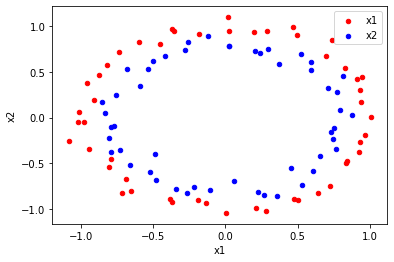

After transformation
Encoder
Edges:  500
Incorrect:  132
Applying TSNE


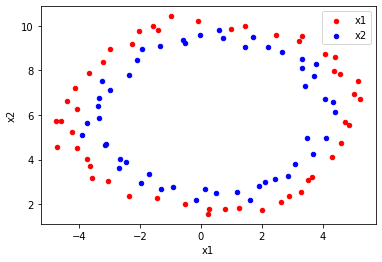

latent
Edges:  500
Incorrect:  152


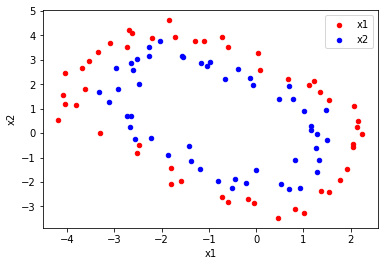

In [1464]:
transformData(model, trainer, dm)

In [1465]:
if __name__ == "__main__":    
    None

In [1466]:
# class AE(pl.LightningModule):

#     def __init__(self, *args, **kwargs):
#         super().__init__()

#         self.save_hyperparameters()
#         #self.latent_dim=self.hparams.latent_dim        
        
#         self.latent_dim=2
        
#         self.lr=self.hparams.lr        
#         hidden=512

#         self.encoder=nn.Sequential(
#             nn.Linear(2, hidden),
#             nn.Tanh(),
#             nn.Linear(hidden, self.latent_dim),
#             nn.Tanh(),
#         )
        
#         self.decoder=nn.Sequential(
#             nn.Linear(self.latent_dim, hidden),
#             nn.Tanh(),
#             nn.Linear(hidden, 2),
#             nn.Tanh()
#         )

   
#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
        
#         return x

#     def step(self, batch, batch_idx):
#         x, y = batch        
#         x_hat = self(x)

#         recon_loss = F.mse_loss(x_hat, x, reduction='mean')

#         loss = recon_loss

#         logs = {
#             "recon_loss": recon_loss,            
#             "loss": loss,
#         }
#         return loss, logs

#     def training_step(self, batch, batch_idx):
#         loss, logs = self.step(batch, batch_idx)
#         self.log_dict({f"train_{k}": v for k, v in logs.items()}, on_step=True, on_epoch=False)
#         return loss

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=self.lr)